In [1]:
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import matplotlib.pyplot as plt
from PIL import Image


In [2]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

cuda


In [3]:
train_path='C:/Users/dell/Desktop/200v/train'
test_path='C:/Users/dell/Desktop/200v/val'

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=64, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=32, shuffle=True
)



In [4]:
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

['cattle_0300', 'cattle_0500', 'cattle_0600', 'cattle_0700', 'cattle_0800', 'cattle_1400', 'cattle_1600', 'cattle_1800', 'cattle_2000', 'cattle_2300', 'cattle_2320', 'cattle_2700', 'cattle_2710', 'cattle_2900', 'cattle_3000', 'cattle_3100', 'cattle_3200', 'cattle_3300', 'cattle_3814', 'cattle_3819', 'cattle_3842', 'cattle_3844', 'cattle_3847', 'cattle_3856', 'cattle_4208', 'cattle_4323', 'cattle_4339', 'cattle_4347', 'cattle_4363', 'cattle_4369', 'cattle_4422', 'cattle_4539', 'cattle_4668', 'cattle_4678', 'cattle_4679', 'cattle_4680', 'cattle_4716', 'cattle_4748', 'cattle_4775', 'cattle_4804', 'cattle_4819', 'cattle_4840', 'cattle_4921', 'cattle_4947', 'cattle_5009', 'cattle_5028', 'cattle_5066', 'cattle_5073', 'cattle_5077', 'cattle_5090', 'cattle_5112', 'cattle_5171', 'cattle_5197', 'cattle_5207', 'cattle_5273', 'cattle_5275', 'cattle_5283', 'cattle_5314', 'cattle_5362', 'cattle_5404', 'cattle_5408', 'cattle_5410', 'cattle_5427', 'cattle_5432', 'cattle_5509', 'cattle_5559', 'cattle_5

In [5]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=100):
        super(ConvNet,self).__init__()
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        self.bn1=nn.BatchNorm2d(num_features=12)
        self.relu1=nn.ReLU()
        self.pool=nn.MaxPool2d(kernel_size=2)
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        self.relu2=nn.ReLU()
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.bn3=nn.BatchNorm2d(num_features=32)
        self.relu3=nn.ReLU()
        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
        output=self.pool(output)
        output=self.conv2(output)
        output=self.relu2(output)
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
        output=output.view(-1,32*75*75)
        output=self.fc(output)
        return output

In [6]:
model=ConvNet(num_classes=100).to(device)
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()
num_epochs=20
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))
print(train_count,test_count)
best_accuracy=0.0

1299 371


Epoch: 0 Train Loss: tensor(49.1271) Train Accuracy: 0.2686682063125481 Test Accuracy: 0.09973045822102426
Epoch: 1 Train Loss: tensor(4.4179) Train Accuracy: 0.8229407236335643 Test Accuracy: 0.5956873315363881
Epoch: 2 Train Loss: tensor(1.4018) Train Accuracy: 0.9253271747498075 Test Accuracy: 0.9245283018867925
Epoch: 3 Train Loss: tensor(0.3235) Train Accuracy: 0.9722863741339491 Test Accuracy: 0.9622641509433962
Epoch: 4 Train Loss: tensor(0.2325) Train Accuracy: 0.9815242494226328 Test Accuracy: 0.9514824797843666
Epoch: 5 Train Loss: tensor(0.2949) Train Accuracy: 0.976905311778291 Test Accuracy: 0.954177897574124
Epoch: 6 Train Loss: tensor(0.1921) Train Accuracy: 0.985373364126251 Test Accuracy: 0.9191374663072777
Epoch: 7 Train Loss: tensor(0.1326) Train Accuracy: 0.9884526558891455 Test Accuracy: 0.9514824797843666
Epoch: 8 Train Loss: tensor(0.1377) Train Accuracy: 0.9861431870669746 Test Accuracy: 0.954177897574124
Epoch: 9 Train Loss: tensor(0.2001) Train Accuracy: 0.985

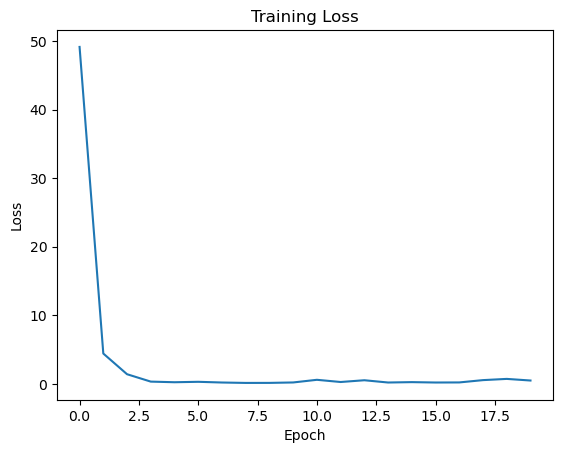

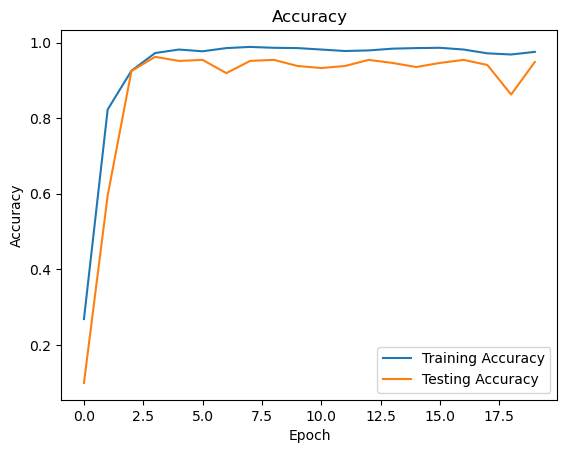

In [7]:
import matplotlib.pyplot as plt

train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
        optimizer.zero_grad()
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        train_accuracy+=int(torch.sum(prediction==labels.data))
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    test_accuracy=test_accuracy/test_count
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=test_accuracy
        
# Plot the training loss
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot the training and testing accuracy
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Testing Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
